# Examining Racial Discrimination in the US Job Market

### Background
Racial discrimination continues to be pervasive in cultures throughout the world. Researchers examined the level of racial discrimination in the United States labor market by randomly assigning identical résumés to black-sounding or white-sounding names and observing the impact on requests for interviews from employers.

### Data
In the dataset provided, each row represents a resume. The 'race' column has two values, 'b' and 'w', indicating black-sounding and white-sounding. The column 'call' has two values, 1 and 0, indicating whether the resume received a call from employers or not.

Note that the 'b' and 'w' values in race are assigned randomly to the resumes when presented to the employer.

### Exercises
You will perform a statistical analysis to establish whether race has a significant impact on the rate of callbacks for resumes.

Answer the following questions **in this notebook below and submit to your Github account**. 

   1. What test is appropriate for this problem? Does CLT apply?
   2. What are the null and alternate hypotheses?
   3. Compute margin of error, confidence interval, and p-value.
   4. Write a story describing the statistical significance in the context or the original problem.
   5. Does your analysis mean that race/name is the most important factor in callback success? Why or why not? If not, how would you amend your analysis?

You can include written notes in notebook cells using Markdown: 
   - In the control panel at the top, choose Cell > Cell Type > Markdown
   - Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet


#### Resources
+ Experiment information and data source: http://www.povertyactionlab.org/evaluation/discrimination-job-market-united-states
+ Scipy statistical methods: http://docs.scipy.org/doc/scipy/reference/stats.html 
+ Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet
****

In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
%matplotlib inline

In [2]:
data = pd.io.stata.read_stata('data/us_job_market_discrimination.dta')

In [21]:
# number of callbacks for black-sounding names
num_black = len(data[data.race=='b'])
num_white = len(data[data.race=='w'])
print('totals; black white:', num_black, num_white)

calls_black = sum(data[data.race=='b'].call)
calls_white = sum(data[data.race=='w'].call)
print('total calls; black white:', calls_black, calls_white)

ratio_black = calls_black/num_black
ratio_white = calls_white/num_white
print('ratios; black white:', ratio_black, ratio_white)

totals; black white: 2435 2435
total calls; black white: 157.0 235.0
ratios; black white: 0.064476386037 0.0965092402464


In [19]:
data[['race','call']].head(5)

,race,call
0,w,0.0
1,w,0.0
2,b,0.0
3,b,0.0
4,w,0.0


# Does race have a significant impact on rate of callbacks for a resume?

## 1. What test is appropriate for this problem? Does CLT apply?
    CLT applies if we are looking at the rate, we can see if the distribution of callback rates is normal in a bootstrap test. A two-sample bootstrap test seems appropriate for this problem. 

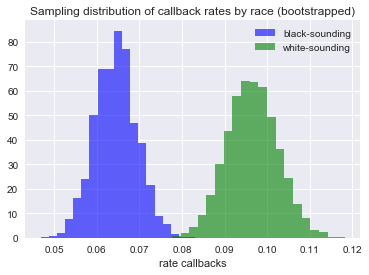

In [75]:
# Random sample to get a vector of callback rates (aka sums of calls)
def bootstrap_mean(data, nSample, nIter=10000):
    mean_list = []
    np.random.seed(100)

    for i in range(nIter):
        sample = np.random.choice(data, size = nSample)
        mean_list.append(np.mean(sample))

    # Convert to series
    series = pd.Series(mean_list)

    return series

b_calls = data[data.race=='b'].call
w_calls = data[data.race=='w'].call
r_black = bootstrap_mean(b_calls, 2435)
r_white = bootstrap_mean(w_calls, 2435)
#histogram
_ = plt.hist(r_black, bins = 20, normed=True, color='blue', alpha=.6, label='black-sounding')
_ = plt.hist(r_white, bins = 20, normed=True, color='green', alpha=.6, label='white-sounding')
_ = plt.title("Sampling distribution of callback rates by race (bootstrapped)")
_ = plt.xlabel('rate callbacks')
_ = plt.legend()
plt.show()

## 2. What are the null and alternate hypotheses?
    The null hypothesis is that the difference in rate of callback between black-sounding names and white-sounding names is not statistically significant. 
    The alternative hypothesis is that there is a statistically significant difference in the rate of callback between black-sounding names and white-sounding names, and that black-sounding names receive less callbacks. 

## 3. Compute margin of error, confidence interval, and p-value.

In [86]:
#first lets get the mean of our data set
mean_cbs = data.call.mean()

print('mean rate= ', mean_cbs)
sample_diff_mean= b_calls.mean() - w_calls.mean()

std_err = np.sqrt(r_black.var() + r_white.var())
mgn_err = 1.96 * std_err 
print('margin of error: ', mgn_err)
print('confidence interval is between ', 0-mgn_err, ' and ', mgn_err)
diff_mean = b_calls.mean() - w_calls.mean()
print('diff of means: ', diff_mean )
#we want to test null hypothesis that black-sounding names and white sounding names have the same rate
#first shift the rates of our two sample sets to match the rate of the set as a whole
data_black_shifted = b_calls - b_calls.mean() + mean_cbs
data_white_shifted = w_calls - w_calls.mean() + mean_cbs

#get new bootstrapped means
rate_black = bootstrap_mean(data_black_shifted, 2435, 10000)
rate_white = bootstrap_mean(data_white_shifted, 2435, 10000)

#test
diff_means = rate_black - rate_white
p_value = np.sum(diff_means <= sample_diff_mean)/(len(diff_means))
print('p_value via bootstrap, 10000 samples: ', p_value)
results = stats.ttest_ind(w_calls,b_calls)
print('p-value via scipy: ', results[1])

mean rate=  0.08049281686544418
margin of error:  0.0152665818075
confidence interval is between  -0.0152665818075  and  0.0152665818075
diff of means:  -0.03203285485506058
p_value via bootstrap, 10000 samples:  0.0
p-value via scipy:  3.94080210313e-05


## 4. Write a story describing the statistical significance in the context or the original problem.
    When given a random resume with either a black-sounding or white-sounding name, employers were more likely to call a white-sounding name for an interview.

## 5. Does your analysis mean that race/name is the most important factor in callback success? Why or why not? If not, how would you amend your analysis?
    This does not necessarily mean race/name is the most important factor, this study only looked at the difference between race and call-back rate but there is a lot more than just someone's name on their resume that could also play a part in whether they get a call-back.  